# Test SSD



## Preliminares

* Descargamos el proyecto de GitHub para poder trabajar con los módulos creados para la red SSD300.
* Descargamos el modelo desde dropbox para poder realizar la predicción sobre el dataset de test.

In [0]:
!wget -O /tmp/SSD300/mimodelo.hdf5 "https://www.dropbox.com/s/yruc3doghdzw1jg/checkpoint-25-1.2632.hdf5?dl=0"

--2019-01-19 22:29:47--  https://www.dropbox.com/s/yruc3doghdzw1jg/checkpoint-25-1.2632.hdf5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yruc3doghdzw1jg/checkpoint-25-1.2632.hdf5 [following]
--2019-01-19 22:29:47--  https://www.dropbox.com/s/raw/yruc3doghdzw1jg/checkpoint-25-1.2632.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe5b0e5cf1cc994eabd08bf22d.dl.dropboxusercontent.com/cd/0/inline/AZt2KVFHpW4qoi7y5Ua-HFysOYtkLQHPgWuTKv3C-6NkbqQazw7yB-3yRNUXDDPSvOE9XlYfUoxJmohWLaKKzZJ42cXTDE4zKSZSxksbaU74DpKjL9yR9a9fGz6frpfO7_4GEVcx48GK7-Z3uzeCdlAHOq1LcoihD3PFRueMALCzDKWY4YdNOi4mHspfIo-x9lk/file# [following]
--2019-01-19 22:29:48--  https://ucfe5b0e5cf1cc994eabd08bf22d.dl.dropboxusercontent.com/cd/0/inline/AZt2KV

Nos posicionamos en la ruta donde se encuentran los paquetes descargados para facilitar la interacción con ellos.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/Colab Notebooks/mova/patrones/practica2_2/keras-ssd/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/mova/patrones/practica2_2/keras-ssd


 ## Carga del modelo
 
1.   Indicamos las clases a detectar (RBC, WBC, Platelets).
2.   Instanciamos la red de detección SSD.
3.   Cargamos los pesos obtenidos en el entrenamiento.

Es necesario que el input de la red sea 300x300 ya que la SSD usada esta implementada de este modo.

In [0]:
from SSD300.ssd_v2 import SSD300v2
voc_classes = ['RBC', 'WBC', 'Platelets']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)
model.load_weights('/tmp/SSD300/mimodelo.hdf5', by_name=True)

## Detección



Cargamos las prior boxes tal y como se indica en el paper referente a la red SSD.

In [0]:
import pickle
from SSD300.ssd_utils import BBoxUtility

priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

Realizamos la predicción y detección de nuestras clases.

En primer lugar cargaremos los targets de nuestro dataset de test, una vez cargados los target se cargan las imágenes asoaciadas a los mismos. Para finalmente realizar la predicción y detección de los bounding boxes que contengan las clases buscadas.

El método __detecdetection_out__ es el encargado de realizar non maximal supressión sobre las predicciónes para obtener los mejores resultados de detección.

In [0]:
from get_label_from_XML import XML_labels
from keras.preprocessing import image
import imageio
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
from metrics.labels import FileLabels

# Load target
y_test = XML_labels(data_path='./dataset_rbc/test/Annotations/')
keys = list(y_test.data.keys())

# Load the images belonging to the labels
inputs = []
images = []
for key in keys:
  img_path = './dataset_rbc/test/images/' + key
  img = image.load_img(img_path, target_size=(300, 300))
  img = image.img_to_array(img)
  
  images.append(img_path)
  inputs.append(img.copy())

# Predict  
inputs = preprocess_input(np.array(inputs))
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

36/36 [==============================] - 42s 1s/step


### Creación de etiqueas para el groundtruth

Crearemos un fichero de etiquetas para el groundtruth y posteriormente para las detecciones realizadas, con el fin de medir el rendimiento a través de las métricas __AP__ y __mAP__.

Creamos la función __get_cell_class__ para la creación de las etiquetas asociadas a los vectores one hot que nos informan de la clase a la que pertenece cada objeto detectado.

In [0]:
def get_cell_class(one_hot_vector):
  
  if one_hot_vector[0] == '1':
    name = 'RBC'
  elif one_hot_vector[1] == '1':
    name = 'WBC'
  elif one_hot_vector[2] == '1':
    name = 'Platelets'
    
  return name

Nos apoyaremos en la función anterior y en el módulo __labels__ para generar los ficheros de etiquetas asociadnos a cada imagen de test (groundtruth).

In [0]:
from metrics.labels import FileLabels

# Create/Reset de path to groundtruth
fl = FileLabels('./labels/groundtruths/')

# Create the label files (class_name | x | y | w | h)
for bbox in keys:
  filename = bbox.replace('.jpg', '')
  fl.create(filename)
  for item in y_test.data[bbox]:
    cell_class = get_cell_class(item[4:])
    fl.append(cell_class, None, item[0], item[1], item[2], item[3])
  fl.save()  

## Resultados



1.   En base a las predicciones realizadas mostramos mediante matplotlib los bounding boxes correspondientes a la detección de las distintcas clases.
2.   Al mismo tiempo que obtenemos los bounding boxes creamos los ficheros de etiquetas necesarios para el cálculo de las métricas __AP__ y __mAP__.
3.   Finalmente mostramos los resultados de la detección.



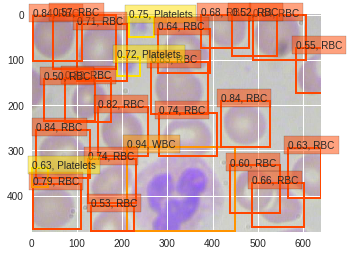

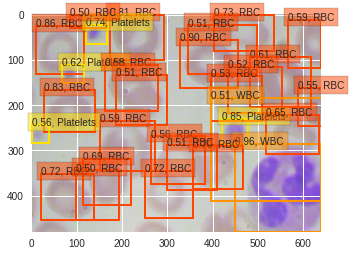

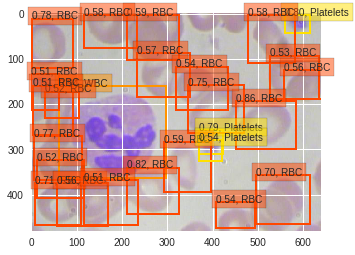

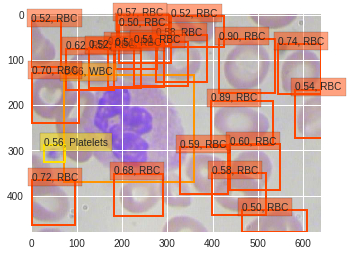

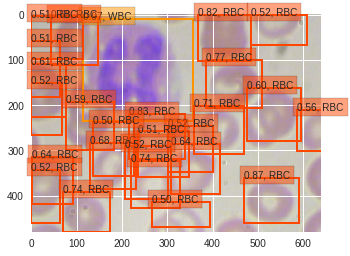

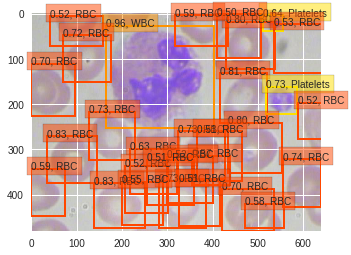

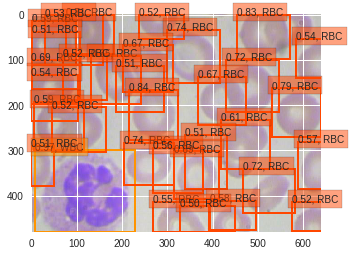

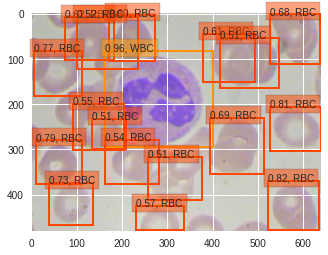

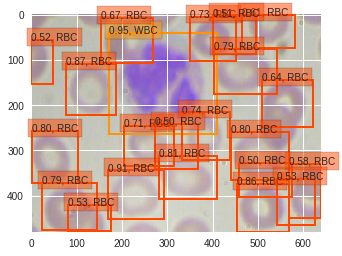

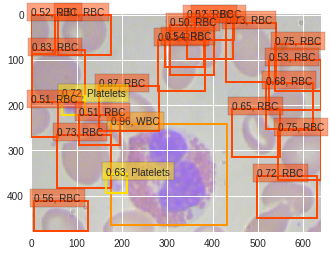

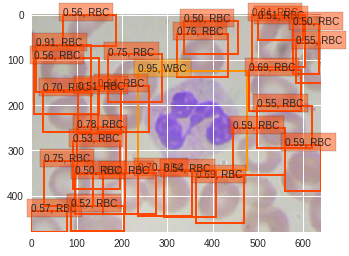

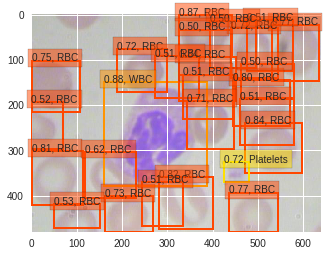

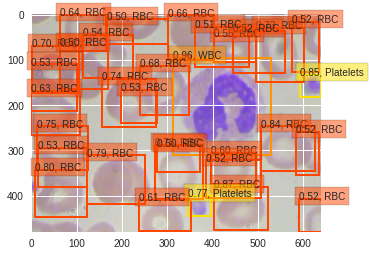

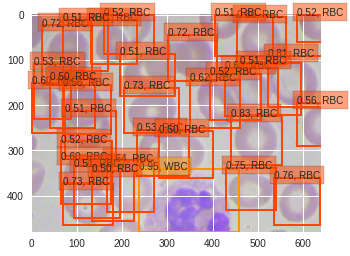

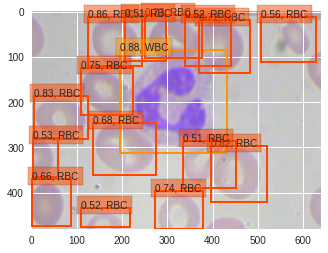

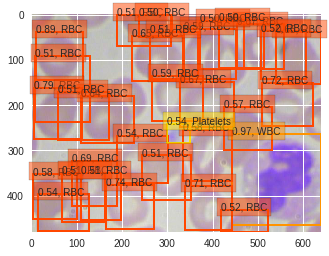

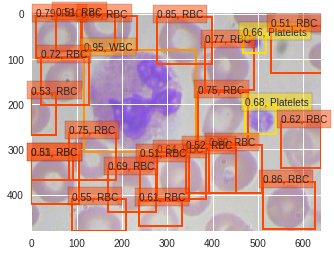

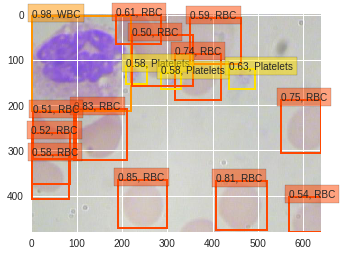

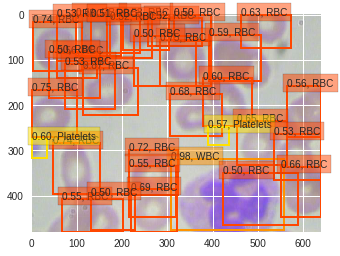

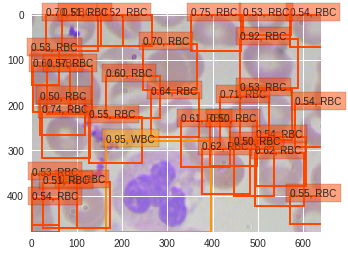

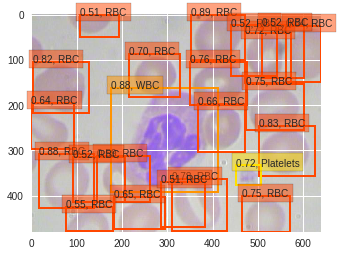

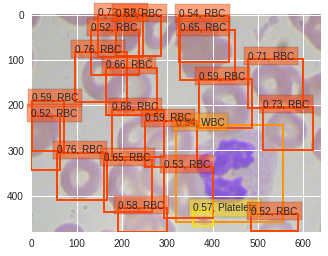

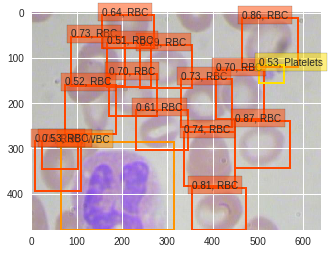

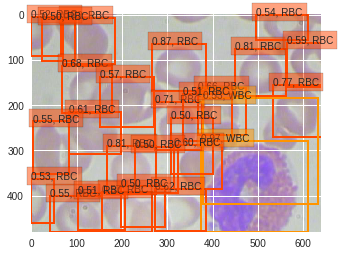

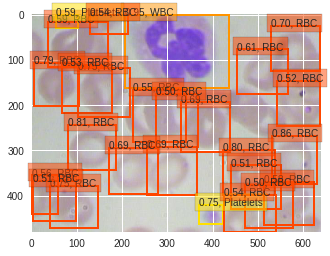

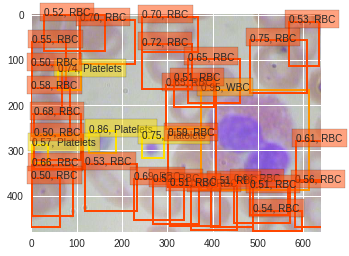

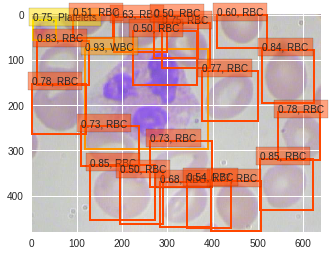

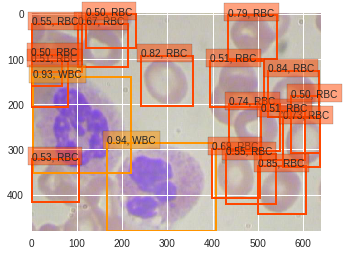

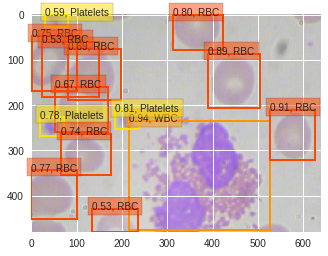

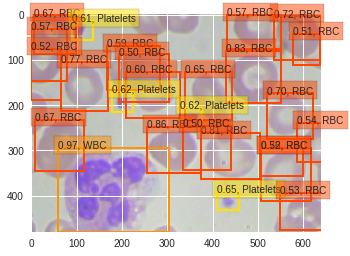

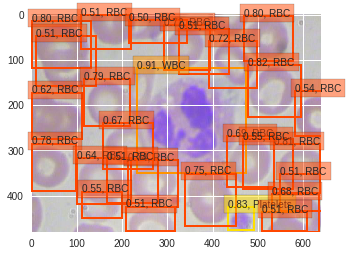

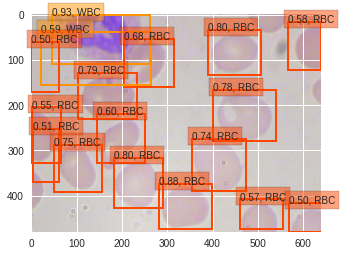

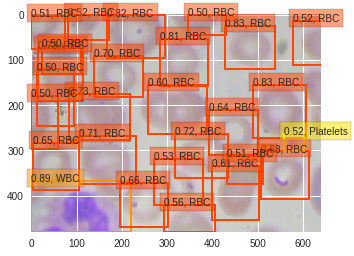

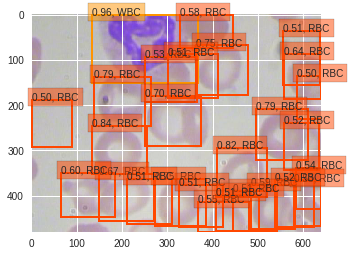

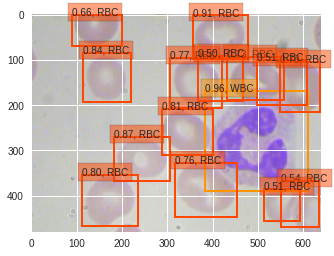

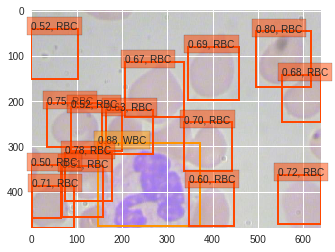

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create/Reset de path to detections
fl = FileLabels('./labels/detections/')

for i, img_path in enumerate(images):
  filename = img_path.split('/')[-1].replace('.jpg', '')
  fl.create(filename)
  
  img = imageio.imread(img_path)  
  
  # Parse the outputs.
  det_label = results[i][:, 0]
  det_conf = results[i][:, 1]
  det_xmin = results[i][:, 2]
  det_ymin = results[i][:, 3]
  det_xmax = results[i][:, 4]
  det_ymax = results[i][:, 5]

  # Get detections with confidence higher than 0.6.
  top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

  top_conf = det_conf[top_indices]
  top_label_indices = det_label[top_indices].tolist()
  top_xmin = det_xmin[top_indices]
  top_ymin = det_ymin[top_indices]
  top_xmax = det_xmax[top_indices]
  top_ymax = det_ymax[top_indices]

  colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

  plt.imshow(img / 255.)
  currentAxis = plt.gca()

  for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = voc_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    # Create the label files (class_name | x | y | w | h)
    fl.append(label_name, score, xmin, ymin, xmax, ymax)
  
  # Save de label detection file
  fl.save()    
  plt.show()

## Rendimiento

Calculamos el __AP__ para cada una de las clases y el __mAP__ global. Para ello nos basamos en el módulo __metrics__. Mostramos las gráficas correspondientes a cada clase y los porcentajes obtenidos.

Los datos obtenidos estan entorno a:
* AP: 87.96% (Platelets)
* AP: 93.89% (RBC)
* AP: 100.00% (WBC)
* mAP: 93.95%

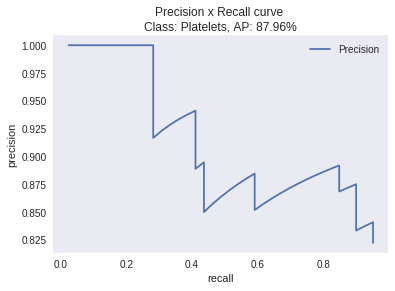

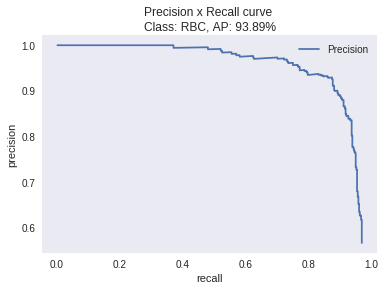

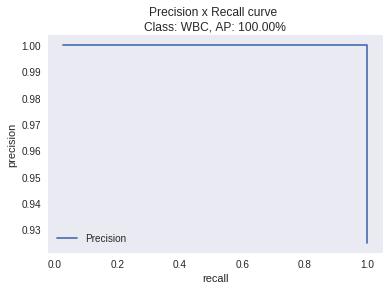

AP: 87.96% (Platelets)
AP: 93.89% (RBC)
AP: 100.00% (WBC)
mAP: 93.95%


In [0]:
import os
from metrics.metrics import Metrics

currentPath = os.path.dirname(os.path.abspath('__file__'))

m = Metrics(currentPath=currentPath,
            gtFormat='xywh',
            detFormat='xywh',
            gtFolder=os.path.join(currentPath, 'labels/groundtruths'),
            gtCoordinates='abs',
            detCoordinates='abs',
            imgSize=None,
            detFolder=os.path.join(currentPath, 'labels/detections'),
            iouThreshold=0.5
            )

m.run()
